In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
!pip install torch==1.3.1  -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [27]:
from __future__ import division
# from fastai.vision import *
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils_data

from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pylab as plt
import sklearn as skl
from pathlib import Path
import numpy as np

In [28]:
torch.__version__

'1.3.1+cu92'

In [29]:
torch.manual_seed(1) 

## Get data

In [30]:
path=Path('./')

# Arma

## Read data and do fc map


In [31]:
from sklearn import preprocessing
import sklearn as skl
from sklearn.model_selection import train_test_split
dataroot=path
trainpath= dataroot/'X2.npy'
X=np.load(trainpath)

gtpath=dataroot/'Y.npy'
Y=np.load(gtpath)


fc_map = np.poly1d([-1.49603151e+00,  1.83220575e+02, -7.72644152e+03,  1.38367935e+05, -8.78011290e+05])
def map_fric_to_coh(fric):
    if fric==0: return 0
    return fc_map(fric)

new_feature = np.vectorize(map_fric_to_coh)(X[:,:12]) + X[:,12:]
X = np.hstack((X, new_feature))
# split the data into train and test dataset 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=2)

# do processing 
scaler = skl.preprocessing.StandardScaler()
yscaler = skl.preprocessing.PowerTransformer() #StandardScaler()
scaler.fit(X_train)
yscaler.fit(y_train.reshape(-1,1))
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = yscaler.transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = yscaler.transform(y_test.reshape(-1,1)).ravel()

In [39]:
# convert the numpy array to torch tensor 
dtype = torch.FloatTensor # uncomment for CPU
#dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU
inputs = torch.from_numpy(X_train_scaled.astype(np.float32)).type(dtype)
targets = torch.from_numpy(y_train_scaled.astype(np.float32)).type(dtype)
inputs_test= torch.from_numpy(X_test_scaled.astype(np.float32)).type(dtype)
targets_test= torch.from_numpy(y_test_scaled.astype(np.float32)).type(dtype)
# sns.distplot(Y_scaled, hist=False, color="b", label="GT power transformation" , ax=ax1);

In [40]:
print(inputs.size())
print(targets.size())
print(inputs_test.size())
print(targets_test.size())


torch.Size([75006, 36])
torch.Size([75006])
torch.Size([25003, 36])
torch.Size([25003])


In [41]:
# create dataset for pytorch and create dataloader for training 
training_samples = utils_data.TensorDataset(inputs, targets)
data_loader_trn = utils_data.DataLoader(training_samples, batch_size=200, drop_last=False, shuffle=True)

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out2 = self.fc2(F.leaky_relu(self.fc1(x)))
        out3 = self.fc3(F.leaky_relu(out2))
        out4 = self.fc4(F.leaky_relu(out3))
        out = self.fc5(F.leaky_relu(out4))
        return out

In [43]:
# set up hyperparameters 
input_size = inputs.size()[1]
hidden_size = 58
output_size = 1
num_epoch = 1000
learning_rate = 1e-3

In [44]:
#  instance the model and define an optimizer, loss function 
model = MLP(input_size = input_size, hidden_size = hidden_size,
            output_size = output_size)
#model.cuda() # uncomment for GPU

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=0.01,amsgrad= True) 
loss_fct = nn.MSELoss() 

In [45]:
#train
for epoch in range(num_epoch):
        cum_loss = 0
        for batch_idx, (data, target) in enumerate(data_loader_trn):

            tr_x, tr_y = data.float(), target.float()
            # tr_x = tr_x.view(200, -1)
            # print(tr_x.shape)
            pred = model(tr_x)
            loss = loss_fct(pred, tr_y.unsqueeze(1)) #loss_fct(pred, tr_y)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += loss.item()
            
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                      %(epoch+1, num_epoch, cum_loss))

Epoch [1/1000], Loss: 107.8547
Epoch [11/1000], Loss: 8.7423
Epoch [21/1000], Loss: 5.4751
Epoch [31/1000], Loss: 4.3592
Epoch [41/1000], Loss: 3.7452
Epoch [51/1000], Loss: 3.4133
Epoch [61/1000], Loss: 3.1497
Epoch [71/1000], Loss: 3.0565
Epoch [81/1000], Loss: 2.7568
Epoch [91/1000], Loss: 2.8303
Epoch [101/1000], Loss: 2.5193
Epoch [111/1000], Loss: 2.4639
Epoch [121/1000], Loss: 2.3751
Epoch [131/1000], Loss: 2.2768
Epoch [141/1000], Loss: 2.3372
Epoch [151/1000], Loss: 2.2308
Epoch [161/1000], Loss: 2.2183
Epoch [171/1000], Loss: 2.1430
Epoch [181/1000], Loss: 2.1404
Epoch [191/1000], Loss: 2.0561
Epoch [201/1000], Loss: 2.0766
Epoch [211/1000], Loss: 2.0419
Epoch [221/1000], Loss: 2.0470
Epoch [231/1000], Loss: 1.9750
Epoch [241/1000], Loss: 1.9728
Epoch [251/1000], Loss: 2.0245
Epoch [261/1000], Loss: 1.9707
Epoch [271/1000], Loss: 1.9218
Epoch [281/1000], Loss: 2.0177
Epoch [291/1000], Loss: 1.9467
Epoch [301/1000], Loss: 1.8729
Epoch [311/1000], Loss: 1.9394
Epoch [321/1000],

In [46]:
# do prediction on the test data 
final_prediction = model(inputs_test)
final_pred_np = final_prediction.clone().detach().numpy()
mae=np.abs(y_test_scaled-final_pred_np.squeeze(1))
print('mae {}'.format(np.mean(mae)))
index=np.where(mae<0.02)
erro2=100*index[0].shape[0]/y_test_scaled.shape[0]
print('percentage of less than 2% is {}'.format(erro2))

mae 0.056625225899991985
percentage of less than 2% is 24.713034435867694


In [ ]:
# load the results obtained by sklearn MLP 
re_sklearn=np.load(path/'sklearn_mlp_output.npy')

In [ ]:
# compute the evaluation metric on the result of sklearn MLP 
mae1=np.abs(y_test_scaled-re_sklearn)
print('sklearn MLP mae  {}'.format(np.mean(mae1)))
index=np.where(mae1<0.02)
erro2=100*index[0].shape[0]/y_test_scaled.shape[0]
print('sklearn MLP percentage of less than 2% is {}'.format(erro2))

sklearn MLP mae  0.059167224726049794
sklearn MLP percentage of less than 2% is 23.625164980202374


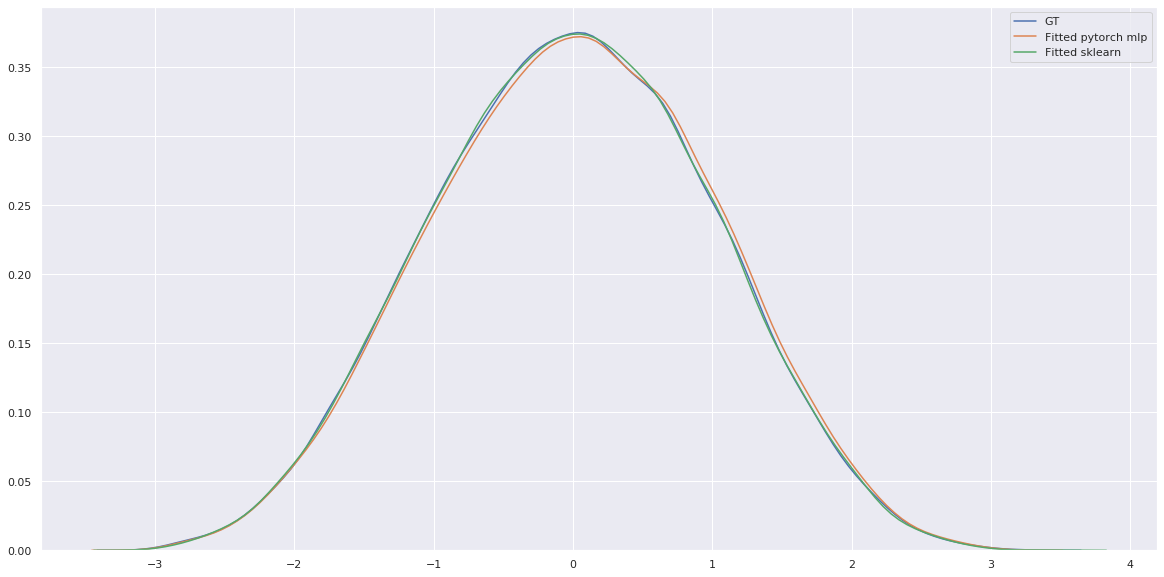

In [ ]:
# visualize the fitted result
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
ax1 = sns.distplot(y_test_scaled, hist=False, label="GT")
sns.distplot(final_pred_np, hist=False, label="Fitted pytorch mlp" , ax=ax1);
sns.distplot(re_sklearn, hist=False, label="Fitted sklearn" , ax=ax1);

In [ ]:
# save model
torch.save(model.state_dict(), path/'models'/'mlp-adamW')